# Imports

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# General
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import pandas as pd
sns.set()

# keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, InputLayer, Conv1D, Flatten, MaxPool1D, BatchNormalization, MaxPooling1D
from keras.layers import PReLU 
from keras.initializers import glorot_uniform
from keras import optimizers

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler,StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import scipy.stats as scistats

# Importing Datasets

In [ ]:
df_mean   = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS 711 Assignment 3/data/data_cleaned_means.csv'       )
df_median = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS 711 Assignment 3/data/data_cleaned_median.csv'      )
df_knn    = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS 711 Assignment 3/data/data_cleaned_knn.csv'         )
df_mice   = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS 711 Assignment 3/data/data_cleaned_mice.csv'        )
df_nans   = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS 711 Assignment 3/data/data_cleaned_nans_removed.csv')

# Matplotlib Parameters

In [ ]:
plt.rcParams.update({
                     'axes.titlesize'  : 22,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.labelsize'  : 16
                     })

plt.rcParams['figure.figsize'] = (10,6) 
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams.keys()

# Data Visualisations

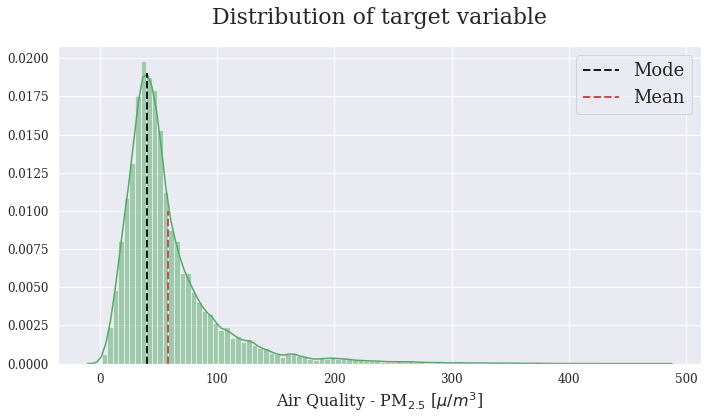

######################################################################################################################################################
------------------------------
Target Variable Description
------------------------------
count    15539.000000
mean        58.242429
std         42.373700
min          1.452619
25%         33.482625
50%         46.504048
75%         68.569062
max        475.820000
Name: target, dtype: float64
######################################################################################################################################################
Percentage of Retained Dataset by removing NaN rows :  46.4122530407362
Not a viable approach as over 50% of the data has been removed
######################################################################################################################################################
------------------------------------------------------------
NaN Percentages (Data Percentages that are not NaNs)
---

In [ ]:
# Visualising the Distribution of the target variable
plt.figure(1)
sns.distplot(df_mean['target'], color='g', bins=100, hist_kws={'alpha': 0.5})
plt.plot([40,40],[0,0.019],'k--',linewidth = 2,label = 'Mode')
plt.plot([58.24242947814734,58.24242947814734],[0,0.01],'r--',linewidth = 2,label = 'Mean')
plt.title('Distribution of target variable',y=1.05)
plt.xlabel(r'Air Quality - PM$_{2.5}$ [$\mu/m^3$]')
plt.legend(loc='best', fontsize = 18)
plt.tight_layout()
plt.show()

print('#'*150)

# Descriptions of the target variable
print('-'*30)
print('Target Variable Description')
print('-'*30)
print(df_median['target'].describe())
print('#'*150)
print('Percentage of Retained Dataset by removing NaN rows : ',(1 - ((df_mean.shape[0] - df_nans.shape[0])/df_mean.shape[0]))*100)
print('Not a viable approach as over 50% of the data has been removed')
print('#'*150)

# NaN's Percentage
temp_not_nans         = 0.794645730098462 * 100
precip_not_nans       = 0.815560846901345 * 100
rel_humidity_not_nans = 0.678293326468884 * 100
wind_dir_not_nans     = 0.533882489220670 * 100
wind_spd_not_nans     = 0.533882489220670 * 100
atmos_press_not_nans  = 0.820387412317395 * 100

print('-'*60)
print('NaN Percentages (Data Percentages that are not NaNs)')
print('-'*60)
print('temp : ',round(temp_not_nans,2) )
print('precip : ',round(precip_not_nans,2) )
print('rel humidity : ',round(rel_humidity_not_nans,2))
print('wind dir : ',round(wind_dir_not_nans,2))
print('wind spd : ',round(wind_spd_not_nans,2))
print('atmos press : ',round(atmos_press_not_nans,2))
print('#'*150)
print('Number of Total Features : 769')
print('-'*60)
print('Aggregate Features : 42')
print('Location Feature : 1')
print('Sensor Features 6*121 = 726')
print('#'*150)

# Feature Importance

In [ ]:
def perturbation_rank(model, x, y, names):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        pred = model.predict(x)
        error = metrics.mean_squared_error(y, pred)  
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

data_mean    = df_mean.drop(columns=['Unnamed: 0','ID','target','temp', 'precip', 'rel_humidity', 'wind_dir','wind_spd', 'atmos_press',])
label_mean   = df_mean['target']

data_median  = df_median.drop(columns=['Unnamed: 0','ID','target','temp', 'precip', 'rel_humidity', 'wind_dir','wind_spd', 'atmos_press',])
label_median = df_median['target']

data_knn     = df_knn.drop(columns=['Unnamed: 0','ID','target','temp', 'precip', 'rel_humidity', 'wind_dir','wind_spd', 'atmos_press',]) 
label_knn    = df_knn['target']

data_mice    = df_mice.drop(columns=['Unnamed: 0','ID','target','temp', 'precip', 'rel_humidity', 'wind_dir','wind_spd', 'atmos_press',]) 
label_mice   = df_mice['target']

# Change to get feature importance of each dataset #######
X = data_mean
yy = label_mean
##########################################################

y = np.array(yy)
y = y.reshape(-1,1)
scalery = StandardScaler().fit(y)
y = scalery.transform(y)

val_per = 0.2
test_per = 0.1

validation = X.shape[0]*val_per
testing = X.shape[0]*test_per
training = X.shape[0] - validation - testing

X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=test_per, random_state=42)
per = 1-(training/X_remain.shape[0])
X_train,X_val,y_train,y_val =  train_test_split(X_remain, y_remain, test_size=per, random_state=42)


scalerX_train = StandardScaler().fit(X_train)
scalerX_val = StandardScaler().fit(X_val)
scalerX_test = StandardScaler().fit(X_test)
X_train = scalerX_train.transform(X_train)
X_val = scalerX_val.transform(X_val)
X_test = scalerX_test.transform(X_test)

input_dim = X_train.shape[1] 
model = Sequential()
model.add(Dense(50,input_dim = input_dim, activation = 'relu'))
model.add(Dense(10 , activation = 'relu'))
model.add(Dense(1,activation='linear'))

names = list(X.columns)
rank = perturbation_rank(model,X_train,y_train,names)

,name,error,importance
0,atmospherepressure24,2.464586,1.000000
1,windspeed56,2.452732,0.995190
2,mean_atmos_press,2.450983,0.994481
3,atmospherepressure85,2.450400,0.994244
4,atmospherepressure39,2.445563,0.992281
...,...,...,...
764,windspeed49,2.368789,0.961130
765,atmospherepressure28,2.367907,0.960772
766,windspeed30,2.367710,0.960693
767,atmospherepressure99,2.366457,0.960184


In [ ]:
display(rank)

In [ ]:
bestfeatures = SelectKBest(score_func=f_regression,k=10)
fit = bestfeatures.fit(X,yy)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))

            Specs       Score
767  windspeed120  626.280879
761  windspeed119  594.498501
617   windspeed95  561.014087
475     newtemp72  552.495017
623   windspeed96  549.575557
335   windspeed48  548.832426
191   windspeed24  548.251192
43       newtemp0  544.999961
187     newtemp24  542.805094
329   windspeed47  542.661258


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# **Data Scaling**

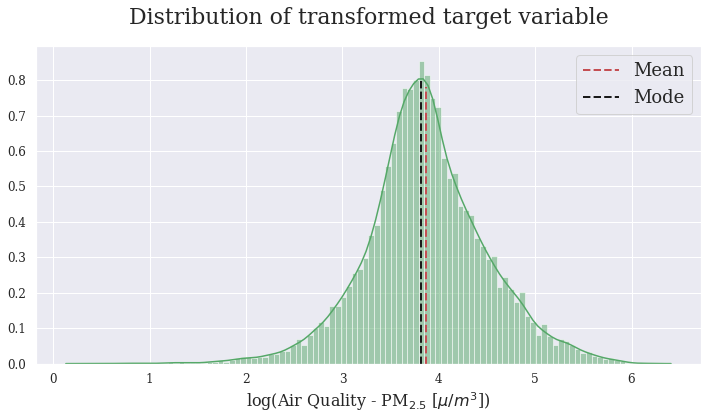


Skewness Before Transformation :  2.6239709949505463
Skewness After Transformation  :  -0.03234474120771468


In [ ]:
plt.figure(2)
sns.distplot(np.log(df_mean['target']), color='g', bins=100, hist_kws={'alpha': 0.5})
plt.plot([np.mean(np.log(df_mean['target'])),np.mean(np.log(df_mean['target']))],[0,0.78],'r--',linewidth = 2,label = 'Mean')
plt.plot([3.82,3.82],[0,0.8],'k--',linewidth = 2,label = 'Mode')
plt.title('Distribution of transformed target variable',y=1.05)
plt.xlabel(r'log(Air Quality - PM$_{2.5}$ [$\mu/m^3$])')
plt.legend(loc='best', fontsize = 18)
plt.tight_layout()
plt.show()

print()
print('Skewness Before Transformation : ',df_mean['target'].skew())
print('Skewness After Transformation  : ',np.log(df_mean['target']).skew())